In [21]:
!set CUDA_LAUNCH_BLOCKING=1
!set TORCH_USE_CUDA_DSA=1

In [22]:
"""
Train a small convolutional neural network (LeNet architecture) on your dataset,
and a small 2 layer fully connected neural network (FCN) with a similar number
of total parameters. Training requirements: 20 epochs, with Cross-Entropy Loss.
You can use any optimizer (e.g. SGD, Adam, SAM, Adadelta, etc...). State the
optimizer you use. To receive 
"""

# https://medium.com/@deepeshdeepakdd2/lenet-5-implementation-on-mnist-in-pytorch-c6f2ee306e37

import torch
SEED = 123
torch.manual_seed(SEED) 

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from torchsummary import summary
from torchinfo import summary
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import warnings
from tqdm import tqdm
from datetime import datetime
warnings.filterwarnings('ignore')

from PIL import Image
import os
import glob

# check OS is Window or Mac
import platform

if platform.system() == 'Windows':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
elif platform.system() == 'Darwin':
    try:
        device = torch.device("mps")
    except:
        device = torch.device("cpu")

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind': float_formatter})

print(device)

cuda


In [23]:
print(len(glob.glob(os.path.join('./img/', '**/*.png'), recursive=True)))

5000


In [24]:
def random_image(folder):
    """random image from folder and subdirectories"""
    image_files = glob.glob(os.path.join(folder, '**/*.png'), recursive=True) + glob.glob(os.path.join(folder, '**/*.jpg'), recursive=True)
    # print(image_files)
    path = np.random.choice(image_files)
    print(f'Opening image: {path}')
    img = Image.open(path)
    return img

In [25]:
# !nvidia-smi

In [26]:
# !nvcc --version

Opening image: img\2\4676.png
(96, 96)
torch.Size([3, 96, 96])


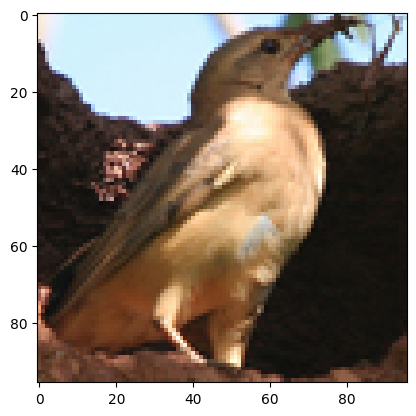

In [27]:
im = random_image('img')
print(im.size)

im_tensor = transforms.ToTensor()(im)
print(im_tensor.shape)

plt.imshow(im)

# **FCN**

In [33]:
import torch
import torch.nn as nn

class CustomFCNetwork(nn.Module):
    def __init__(self):
        super(CustomFCNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 96 * 96, 100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Instantiate the model
model = CustomFCNetwork()

# Print the model architecture and number of trainable parameters
print(model)
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

CustomFCNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=27648, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
Number of trainable parameters: 2768462


In [34]:
model = CustomFCNetwork()

In [35]:
summary(model=model, input_size=(1, 3, 96, 96), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomFCNetwork (CustomFCNetwork)        [1, 3, 96, 96]       [1, 10]              --                   True
├─Flatten (flatten)                      [1, 3, 96, 96]       [1, 27648]           --                   --
├─Linear (fc1)                           [1, 27648]           [1, 100]             2,764,900            True
├─ReLU (relu1)                           [1, 100]             [1, 100]             --                   --
├─Linear (fc2)                           [1, 100]             [1, 32]              3,232                True
├─ReLU (relu2)                           [1, 32]              [1, 32]              --                   --
├─Linear (fc3)                           [1, 32]              [1, 10]              330                  True
Total params: 2,768,462
Trainable params: 2,768,462
Non-trainable params: 0
Total mult-adds (M): 2.77
Input size (MB): 0.11
Forwa

# **dataset**

In [36]:
print(len(glob.glob(os.path.join('./data_split/train/', '**/*.png'), recursive=True)))
print(len(glob.glob(os.path.join('./data_split/test/', '**/*.png'), recursive=True)))

# print number of images per class
print([
    len(glob.glob(os.path.join(f'./data_split/train/{i}', '**/*.png'), recursive=True)) for i in range(1, 11)
])

4697
2197
[473, 469, 465, 468, 474, 469, 469, 470, 467, 473]


In [37]:
from sklearn.model_selection import StratifiedShuffleSplit
dataset_path = './img/'

batch_size = 8      # TODO: cambiarlo a lo que aguante su computadora y relativo a la cantidad de imagenes que tengan

transform = transforms.Compose([
    # transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# train_dataset = CustomDataset('./data_split/train', transform=None)
# val_dataset = CustomDataset('./data_split/test', transform=None)

train_dataset = ImageFolder(root='./data_split/train', transform=transform)
val_dataset = ImageFolder(root='./data_split/test', transform=transform)

print(len(train_dataset), len(val_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataset), len(val_dataset))

4697 2197
4697 2197


In [38]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
accuracy = Accuracy(task='multiclass', num_classes=10)

In [39]:
from sklearn.metrics import f1_score

os.makedirs("./models", exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "STL"
model_name = "FCN"

accuracy = accuracy.to(device)
model = model.to(device)

EPOCHS = 20

best_f1_macro = 0.0
best_model_path = None

for epoch in tqdm(range(EPOCHS)):
    # Training loop
    train_loss, train_acc, train_f1_macro = 0.0, 0.0, 0.0

    y_true = []
    y_pred = []
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        model.train()
        
        predictions = model(X)
        
        loss = loss_fn(predictions, y)
        train_loss += loss.item()
        
        acc = accuracy(predictions, y)
        train_acc += acc
        
        y_true.extend(torch.argmax(predictions, dim=1).tolist())
        y_pred.extend(y.tolist())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_f1_macro = f1_score(y_true, y_pred, average='macro')
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            predictions = model(X)
            
            loss = loss_fn(predictions, y)
            val_loss += loss.item()
            
            acc = accuracy(predictions, y)
            val_acc += acc

            y_pred.extend(torch.argmax(model(X), dim=1).tolist())
            y_true.extend(y.tolist())
            
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        
        val_f1_macro = f1_score(y_true, y_pred, average='macro')
        
        if val_f1_macro > best_f1_macro:
            best_f1_macro = val_f1_macro
            best_model_path = f"./models/best_model_{model_name}.pth"
            torch.save(model.state_dict(), best_model_path)
    
    print(f"Epoch: {epoch}| Train loss: {train_loss:.5f}| Train acc: {train_acc:.5f}| Train F1 Macro: {train_f1_macro:.5f}| Val loss: {val_loss:.5f}| Val acc: {val_acc:.5f}| Val F1 Macro: {val_f1_macro:.5f}")

print(f"Best F1 Macro: {best_f1_macro:.5f} | Best Model Path: {best_model_path}")

  5%|▌         | 1/20 [00:15<04:51, 15.33s/it]

Epoch: 0| Train loss: 2.12178| Train acc: 0.18729| Train F1 Macro: 0.17269| Val loss: 1.91009| Val acc: 0.23645| Val F1 Macro: 0.18781


 10%|█         | 2/20 [00:26<03:53, 12.95s/it]

Epoch: 1| Train loss: 1.95206| Train acc: 0.22832| Train F1 Macro: 0.21940| Val loss: 1.95154| Val acc: 0.22073| Val F1 Macro: 0.17105


 15%|█▌        | 3/20 [00:37<03:21, 11.84s/it]

Epoch: 2| Train loss: 1.90452| Train acc: 0.25021| Train F1 Macro: 0.24083| Val loss: 1.86573| Val acc: 0.25273| Val F1 Macro: 0.21517


 20%|██        | 4/20 [00:48<03:04, 11.55s/it]

Epoch: 3| Train loss: 1.87380| Train acc: 0.26382| Train F1 Macro: 0.25303| Val loss: 1.80992| Val acc: 0.29645| Val F1 Macro: 0.27810


 25%|██▌       | 5/20 [00:58<02:48, 11.24s/it]

Epoch: 4| Train loss: 1.83543| Train acc: 0.29167| Train F1 Macro: 0.27832| Val loss: 1.75783| Val acc: 0.30464| Val F1 Macro: 0.26670


 30%|███       | 6/20 [01:09<02:34, 11.03s/it]

Epoch: 5| Train loss: 1.80520| Train acc: 0.30038| Train F1 Macro: 0.28755| Val loss: 1.78945| Val acc: 0.29800| Val F1 Macro: 0.29079


 35%|███▌      | 7/20 [01:20<02:24, 11.08s/it]

Epoch: 6| Train loss: 1.77299| Train acc: 0.31059| Train F1 Macro: 0.29933| Val loss: 1.74084| Val acc: 0.30982| Val F1 Macro: 0.28636


 40%|████      | 8/20 [01:32<02:16, 11.34s/it]

Epoch: 7| Train loss: 1.74835| Train acc: 0.30952| Train F1 Macro: 0.29601| Val loss: 1.75761| Val acc: 0.31664| Val F1 Macro: 0.29522


 45%|████▌     | 9/20 [01:43<02:04, 11.34s/it]

Epoch: 8| Train loss: 1.72411| Train acc: 0.33291| Train F1 Macro: 0.31571| Val loss: 1.71937| Val acc: 0.31936| Val F1 Macro: 0.29967


 50%|█████     | 10/20 [01:54<01:49, 10.99s/it]

Epoch: 9| Train loss: 1.69934| Train acc: 0.33716| Train F1 Macro: 0.32336| Val loss: 1.78174| Val acc: 0.32382| Val F1 Macro: 0.30685


 55%|█████▌    | 11/20 [02:04<01:37, 10.85s/it]

Epoch: 10| Train loss: 1.68504| Train acc: 0.34630| Train F1 Macro: 0.33384| Val loss: 1.67340| Val acc: 0.35164| Val F1 Macro: 0.31715


 60%|██████    | 12/20 [02:15<01:27, 10.90s/it]

Epoch: 11| Train loss: 1.65206| Train acc: 0.36798| Train F1 Macro: 0.35374| Val loss: 1.64381| Val acc: 0.37855| Val F1 Macro: 0.36537


 65%|██████▌   | 13/20 [02:26<01:15, 10.82s/it]

Epoch: 12| Train loss: 1.63760| Train acc: 0.37075| Train F1 Macro: 0.35499| Val loss: 1.58774| Val acc: 0.39364| Val F1 Macro: 0.38010


 70%|███████   | 14/20 [02:37<01:04, 10.81s/it]

Epoch: 13| Train loss: 1.61826| Train acc: 0.38223| Train F1 Macro: 0.37144| Val loss: 1.59102| Val acc: 0.39855| Val F1 Macro: 0.36945


 75%|███████▌  | 15/20 [02:47<00:53, 10.69s/it]

Epoch: 14| Train loss: 1.58702| Train acc: 0.38946| Train F1 Macro: 0.37621| Val loss: 1.53088| Val acc: 0.42336| Val F1 Macro: 0.40836


 80%|████████  | 16/20 [02:58<00:42, 10.63s/it]

Epoch: 15| Train loss: 1.57337| Train acc: 0.39413| Train F1 Macro: 0.38208| Val loss: 1.54709| Val acc: 0.41400| Val F1 Macro: 0.39559


 85%|████████▌ | 17/20 [03:07<00:31, 10.42s/it]

Epoch: 16| Train loss: 1.56217| Train acc: 0.39605| Train F1 Macro: 0.38508| Val loss: 1.61927| Val acc: 0.37900| Val F1 Macro: 0.35939


 90%|█████████ | 18/20 [03:17<00:20, 10.27s/it]

Epoch: 17| Train loss: 1.52792| Train acc: 0.40774| Train F1 Macro: 0.39738| Val loss: 1.49645| Val acc: 0.41964| Val F1 Macro: 0.41027


 95%|█████████▌| 19/20 [03:27<00:10, 10.17s/it]

Epoch: 18| Train loss: 1.52055| Train acc: 0.42581| Train F1 Macro: 0.41255| Val loss: 1.57199| Val acc: 0.40127| Val F1 Macro: 0.38799


100%|██████████| 20/20 [03:37<00:00, 10.89s/it]

Epoch: 19| Train loss: 1.48178| Train acc: 0.43325| Train F1 Macro: 0.42114| Val loss: 1.53528| Val acc: 0.43573| Val F1 Macro: 0.42555
Best F1 Macro: 0.42555 | Best Model Path: ./models/best_model_FCN.pth


In [45]:
model_uploaded = CustomFCNetwork()
model_uploaded.load_state_dict(torch.load(f"./models//best_model_{model_name}.pth"))

model_uploaded.to(device)

CustomFCNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=27648, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [46]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

model_uploaded.eval()

with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        
        y_pred.extend(torch.argmax(model_uploaded(X), dim=1).tolist())
        y_true.extend(y.tolist())

In [47]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.48      0.57       223
           1       0.60      0.53      0.56       223
           2       0.27      0.33      0.30       219
           3       0.74      0.68      0.71       215
           4       0.17      0.11      0.13       218
           5       0.30      0.58      0.40       224
           6       0.37      0.07      0.12       219
           7       0.34      0.56      0.42       219
           8       0.40      0.36      0.38       220
           9       0.67      0.65      0.66       217

    accuracy                           0.44      2197
   macro avg       0.46      0.44      0.43      2197
weighted avg       0.46      0.44      0.43      2197



In [48]:
print(confusion_matrix(y_true, y_pred))

[[108   7  23   4   9  10   0  27   4  31]
 [  4 118   2  39   9   5   7   9   6  24]
 [ 15   0  73   1  15  58   2  31  23   1]
 [  5  34   0 147  10   1   4   3   0  11]
 [  3   4  30   1  23  76   7  38  34   2]
 [  2   1  32   0  11 129   1  37  11   0]
 [  0   5  39   0  22  45  16  68  24   0]
 [  0   1  22   1  15  36   4 123  17   0]
 [  0   2  41   0  12  60   2  23  80   0]
 [ 18  24  11   6   6   4   0   4   3 141]]


In [49]:
print(confusion_matrix(y_true, y_pred, normalize='true'))

[[0.48 0.03 0.10 0.02 0.04 0.04 0.00 0.12 0.02 0.14]
 [0.02 0.53 0.01 0.17 0.04 0.02 0.03 0.04 0.03 0.11]
 [0.07 0.00 0.33 0.00 0.07 0.26 0.01 0.14 0.11 0.00]
 [0.02 0.16 0.00 0.68 0.05 0.00 0.02 0.01 0.00 0.05]
 [0.01 0.02 0.14 0.00 0.11 0.35 0.03 0.17 0.16 0.01]
 [0.01 0.00 0.14 0.00 0.05 0.58 0.00 0.17 0.05 0.00]
 [0.00 0.02 0.18 0.00 0.10 0.21 0.07 0.31 0.11 0.00]
 [0.00 0.00 0.10 0.00 0.07 0.16 0.02 0.56 0.08 0.00]
 [0.00 0.01 0.19 0.00 0.05 0.27 0.01 0.10 0.36 0.00]
 [0.08 0.11 0.05 0.03 0.03 0.02 0.00 0.02 0.01 0.65]]
